In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets.widgets import interact, interactive, fixed
import ipywidgets as widgets
from scipy import fftpack
from PIL import Image
import pims

In [2]:
info_dict={'interval': 0.01,
 'filename': '400nm_100dil_water_01umpix_100fps_short.cin',
 'muperpix': 0.1,
 'tracer_radius': 0.2,
 'temperature': 25,
 'operator': 'Marco'}

# Example Particle tracking microrheology

## Reading video file

In [3]:
import pims
import trackpy

pims_video=pims.Cine('data/400nm_100dil_water_01umpix_100fps_short.cin')

#Also store the info dictionary from the video object as an attribute of the pims object 
pims_video.info=info_dict

Frame([[119, 118, 116, ..., 127, 125, 125],
       [108, 109, 113, ..., 119, 115, 117],
       [114, 116, 118, ..., 121, 122, 121],
       ...,
       [129, 128, 127, ..., 125, 126, 129],
       [124, 125, 125, ..., 124, 124, 122],
       [118, 117, 115, ..., 116, 117, 115]], dtype=uint8)
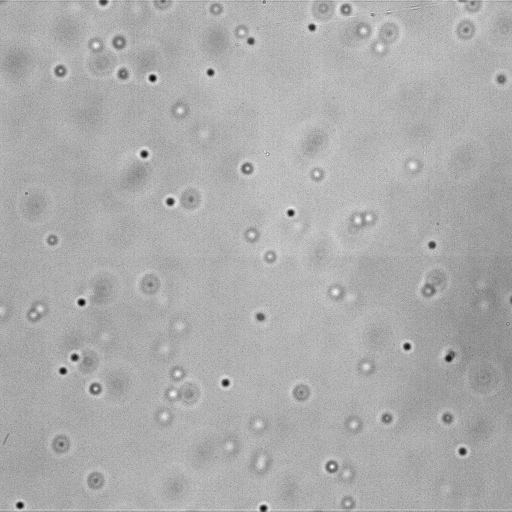

In [4]:
pims_video[2]

In [5]:
#Define simple video browser with ipywidgets

def browse_images_ptm(video):
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        plt.figure(figsize=(6,6))
        toplot=video[framenum]
        plt.title(str(' time: ' + str(framenum*interval) + ' s'))
        plt.imshow(toplot)
        plt.set_cmap('gray')
        plt.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w


In [6]:
browse_images_ptm(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

## Tracking particles position

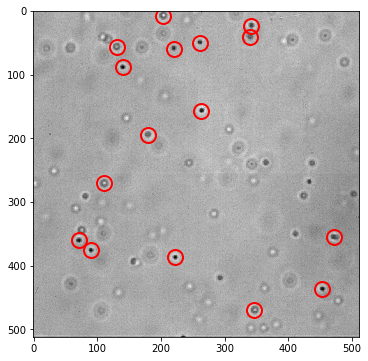

<AxesSubplot:>

In [7]:
import trackpy as tp
fnum=100
plt.figure(figsize=(6,6))
fsingle = tp.locate(pims_video[fnum], 15, invert=True, minmass=1000)
tp.annotate(fsingle, pims_video[fnum])

In [8]:
f = tp.batch(pims_video, 15, minmass=1000, invert=True)
f.to_excel('result_PT.xlsx')

Frame 299: 12 features


ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
pims_video.result_PT=pd.read_excel('result_PT.xlsx')

In [ ]:
def browse_images_tracked(video):
    frames=len(video)
    f=video.result_PT
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        plt.figure(figsize=(8,8))
        toplot=video[framenum]
        plt.title(str(' time: ' + str(framenum*interval) + ' s'))
        plt.imshow(toplot)
        plt.plot(f.x[f.frame==framenum],f.y[f.frame==framenum],'o')
        plt.set_cmap('gray')
        plt.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w

In [ ]:
browse_images_tracked(pims_video)

## Linking trajectories

In [ ]:
t = tp.link_df(f, 5, memory=3)

In [ ]:
t.head()

In [ ]:
t1 = tp.filter_stubs(t, 50)
tp.plot_traj(t1)

## Calculate Mean square displacement

In [ ]:
im = tp.imsd(t1, pims_video.info['muperpix'], pims_video.info['interval']**-1)
fig=im.plot(loglog=True, style='k-', alpha=0.1, legend=False, figsize=(6,6))
fig.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');

## Calculate viscosity from Mean Square Displacement

In [ ]:
em = tp.emsd(t, pims_video.info['muperpix'], pims_video.info['interval']**-1,max_lagtime=50)
em.plot(loglog=True, style='ro', figsize=(5,5))
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')

result=tp.utils.fit_powerlaw(em)
result

For Newtonian liquids:
* $n=1$
* $A=4D$, where $D$ is the particles’ diffusivity.

$D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as:
$$D=\frac{kT}{6 \pi \eta a}$$

In [ ]:
kb=1.380E-23
tempK=273+pims_video.info['temperature']

float(kb*tempK*4/(6*3.14*result.A*1e-12*pims_video.info['tracer_radius']*1E-6))

## Calculate Elastic and Viscous moduli from mean square displacement

In [ ]:
import murheo

In [ ]:
moduli=murheo.msd2G(em.index, em.values, pims_video.info['tracer_radius'], tempK, dim=3, clip=0.03, width=0.7)

In [ ]:
moduli_table=pd.DataFrame.from_dict({'omega':moduli[0],
                        'G*':moduli[1],
                        'Gprime':list(map(lambda x: x.real, moduli[1])),
                        'Gdoubleprime':list(map(lambda x: x.imag, moduli[1]))})

plt.loglog(moduli_table['omega'],moduli_table['Gprime'],'o',color='red')
plt.loglog(moduli_table['omega'],moduli_table['Gdoubleprime'],'o', color='blue')
plt.xlabel('Freq Hz')
plt.ylabel('G\' red G\'\' blue')

plt.plot(moduli_table['omega'],moduli_table['omega']*0.001,color='blue',linestyle='--')